In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## 1.0 Overview
The purpose of this project is to implement a linear regression model form scratch using both the gradient descent algorithm and the normal equation. Parameters derived form manual implementation will then be compared to those learned from a scikit-learn linear regression model.

In [4]:
#  Reading dataset into memory
filepath = 'C:/Users/ORE/Downloads/Car_Purchasing_Data.csv'
dataset = pd.read_csv(filepath)

#  Dataset description
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer Name        500 non-null    object 
 1   Customer e-mail      500 non-null    object 
 2   Country              500 non-null    object 
 3   Gender               500 non-null    int64  
 4   Age                  500 non-null    int64  
 5   Annual Salary        500 non-null    float64
 6   Credit Card Debt     500 non-null    float64
 7   Net Worth            500 non-null    float64
 8   Car Purchase Amount  500 non-null    float64
dtypes: float64(4), int64(2), object(3)
memory usage: 35.3+ KB


### 1.1 Dataset Description
The dataset for this project was sourced from kaggle. It contains information of 500 coustomers across 9 different attributes ranging from customer name to the value of the car purchased by the customer.

#### Definition of Attributes
1. Customer Name - Customer's first and last name.
2. Customer email - Customer's email address.
3. Country - Customer's country of residence.
4. Gender - Customer's gender. 0 (female), 1 (male).
5. Age - Customer's Age.
6. Annual Salary - Annual salary in dollars.
7. Credit Card Debt - Credit card debt in dollars.
8. Net Worth - Net worth in dollars.
9. Car Purchase Amount - Value of the car which was purchased by customer.

Four of the attributes are categorical in nature while otheres are numerical. Gender is considered categorical in this dataset even though it has been binary encoded.

In [5]:
#  Setting float display format
pd.set_option('display.float_format', '{:.2f}'.format)
#  Displaying a preview
dataset.head()

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09,11609.38,238961.25,35321.46
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89,9572.96,530973.91,45115.53
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,USA,1,43,53798.55,11160.36,638467.18,42925.71
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.04,14426.16,548599.05,67422.36
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15,5358.71,560304.07,55915.46


## 2.0 Data Preparation
Data preparation took place in the following steps;
1. Missing value check.
2. Missing value placeholder check.
3. Duplicate check.
4. Cadinality check.
5. Dropping of non-essential columns.

### 2.1 Missing Value Check

In [6]:
#  Checking for missing data
missing = dataset.isnull().sum().sum()

if missing == 0:
    print('There are no missing values in this dataset')
else:
    print(f'There are {missing} missing values in this dataset')

There are no missing values in this dataset


### 2.2 Missing Value Placeholder Check
Some datasets have missing values filled in with a placeholder which is usually zero. For the placeholder check, I will look through attributes where it is impossible to have a realistic value of zero. I have chosen the Age attribute for this.

In [7]:
#  Checking for missing value placeholder
missing_placeholder = dataset[dataset.Age == 0]

if missing_placeholder.shape[0] == 0:
    print('There are no missing value placeholders in the dataset')
else:
    print('There are missing value placeholders in the dataset')

There are no missing value placeholders in the dataset


### 2.3 Duplicate Check

In [8]:
#  Checking for duplicates
duplicates = dataset.duplicated().sum()

if duplicates == 0:
    print('There are no duplicates in this dataset')
else:
    print(f'There are {duplicates} duplicated instances in this dataset')

There are no duplicates in this dataset


### 2.3 Cadinality Check
Here I will investigate the country attribute to see if all customers are resident in the same country or not. This is important as the attribute will be redundant to model building if all entries are from the same country but could be vital if they aren't and the model can possibly learn signals form them.

In [9]:
#  Checking cadinality in Country atrribute
cadinality = len(dataset.Country.unique().tolist())

if cadinality == 1:
    print('All instances are from the same country')
else:
    print('Instances are form more than 1 country')

All instances are from the same country


All entries are indeed from the same country so the country attribute is deemed non-essential.

### 2.4 Dropping of Non-Essential Attributes
Along with the country attribute, attributes Customer Name and Customer email will be dropped as these attributes will obviously have no bearing on a customer's purchasing habits.

In [10]:
#  Dropping non-essential columns
dataset.drop(['Customer Name', 'Customer e-mail', 'Country'], axis=1, inplace=True)

In [11]:
#  Displaying preview
dataset.head()

,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,0,42,62812.09,11609.38,238961.25,35321.46
1,0,41,66646.89,9572.96,530973.91,45115.53
2,1,43,53798.55,11160.36,638467.18,42925.71
3,1,58,79370.04,14426.16,548599.05,67422.36
4,1,57,59729.15,5358.71,560304.07,55915.46


## 3.0 Statistical Description

### 3.1 Numerical Atrributes

In [12]:
dataset.loc[:, 'Age':].describe()

,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
count,500.00,500.00,500.00,500.00,500.00
mean,46.22,62127.24,9607.65,431475.71,44209.80
std,7.99,11703.38,3489.19,173536.76,10773.18
min,20.00,20000.00,100.00,20000.00,9000.00
25%,41.00,54391.98,7397.52,299824.20,37629.90
50%,46.00,62915.50,9655.04,426750.12,43997.78
75%,52.00,70117.86,11798.87,557324.48,51254.71
max,70.00,100000.00,20000.00,1000000.00,80000.00


##### Age
The eldest customer in the dataset is 70yrs old while the youngest is 20yrs old. Average age across the dataset is approximately 46yrs with 25\% of all customers being below the age of 41 while 50\% are above the age of 46.

##### Annual Salary
The average annual salary stands at a little above \\$62,000 with the least earner earning \\$20,000 dollars per year while the highest earner made \\$100,000 annually. 50\% of all customers earned below \\$63,000 however, with only 25\% earning above \\$72,000. 

##### Credit Card debt
The majority of customers (75\%) have a credit carb debt of over \\$7,300, with the minimum owed being \\$100 and the maximum being \\$20,000. The average credit card debt stood at just a little above \\$9,607.

##### Net Worth
The average net worth for instances in this dataset is approximately \\$430,000, with the smallest net worth being \\$20,000 and the largest being \\$1,000,000. 25\% of all customers have a net worth below \\$300,000 while another 25\% have net worths above \\$560,000.

##### Car Purchase Amount
The average value of cars purchased is \\$44,209, with 75\% of all customers purchasing cars valued over \\$37,000. The least spent was \\$9,000 while the most spent was\\$80,000.

#### 3.1.1 Distribution Plots

<AxesSubplot:xlabel='Car Purchase Amount', ylabel='Count'>

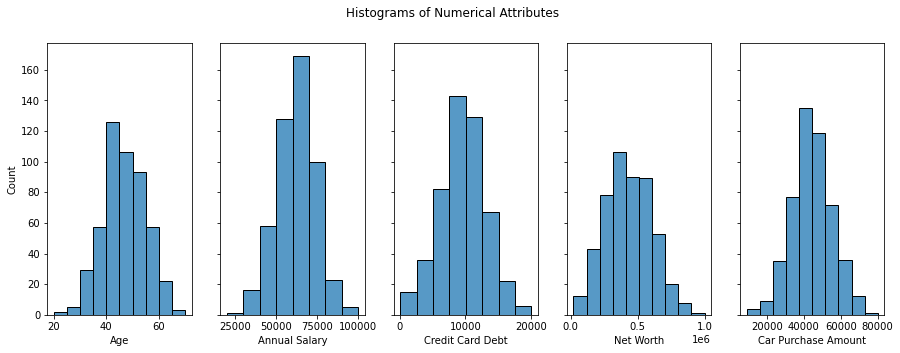

In [13]:
#  Defining a histogram plot function.
def plot_hist(attribute, i, bins='auto'):
    """This function plots histograms"""
    plot = sns.histplot(data=dataset, x=attribute, kde=False, bins=bins, ax=axes[i])
    return plot

#  Plotting
figure, axes = plt.subplots(1, 5, figsize=(15,5), sharey=True)
plt.suptitle('Histograms of Numerical Attributes')

plot_hist('Age', 0, bins=10)
plot_hist('Annual Salary', 1, bins=8)
plot_hist('Credit Card Debt', 2, bins=8)
plot_hist('Net Worth', 3, bins=10)
plot_hist('Car Purchase Amount', 4, bins=10)

### 3.2 Categorical Attributes

<AxesSubplot:xlabel='Gender'>

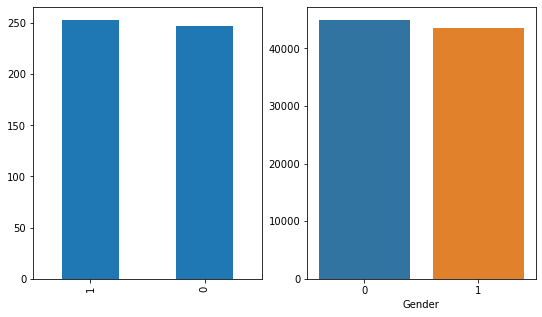

In [14]:
figure, axes = plt.subplots(1,2, figsize=(9,5))

#  Grouping by gender and deriving average purchases
purchase_by_gender = dataset.groupby('Gender')['Car Purchase Amount'].mean()

#  Plotting
dataset.Gender.value_counts().plot(kind='bar', ax=axes[0])
sns.barplot(x=purchase_by_gender.index, y=purchase_by_gender.values, ax=axes[1])

##### Gender
Gender is the only categorical attribute of interest in the dataset. From the plots above we can see that there are identical numbers of men(1) and women(0) in the dataset at a count of approximately 250 for both. It is also evident that on average, women(0) spent slightly more on vehicles compared to men(1) at an average purchase of approximately \\$45,000.

<AxesSubplot:xlabel='Car Purchase Amount', ylabel='Density'>

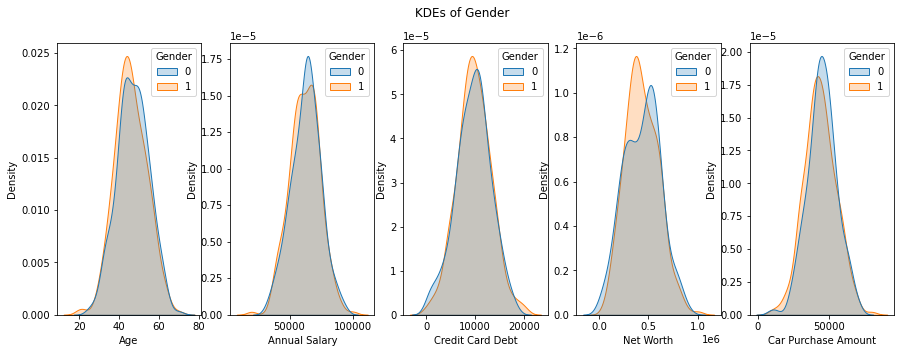

In [91]:
#  Defining a KDE plot function
def plot_kde(attribute, i):
    """This function plots kernel density distributions"""
    plot_k = sns.kdeplot(data=dataset, x=attribute, hue='Gender', shade=True, ax=axes[i])
    return plot_k

#  Plotting
figure, axes = plt.subplots(1, 5, figsize=(15,5))
plt.suptitle('KDEs of Gender')

plot_kde('Age', 0)
plot_kde('Annual Salary', 1)
plot_kde('Credit Card Debt', 2)
plot_kde('Net Worth', 3)
plot_kde('Car Purchase Amount', 4)

From the distribution plots above, it is evident that both genders have similar distributions across numerical attributes. There are however some notable spikes which need to be highlighted. The dataset consists of more middle-aged men (40-50yrs) compared to middle-aged women, also, more women earned annual salaries north of \\$50,000 compared to men.
However, there are more men with credit card debts less than \\$10,000, with more women having net worths higher than \\$500,000 and purchasing cars valued at \\$50,000. 

## 4.0 Feature Selection
Since I am trying to implement a linear regression model, I will be creating a Pearson's Correlation Matrix to check correlation between attributes and the prediction target 'Car Purchase Amount'

In [16]:
# Pearson's Correlation matrix
dataset[['Age', 'Annual Salary', 'Credit Card Debt', 'Net Worth', 'Car Purchase Amount']].corr()['Car Purchase Amount']

Age                   0.63
Annual Salary         0.62
Credit Card Debt      0.03
Net Worth             0.49
Car Purchase Amount   1.00
Name: Car Purchase Amount, dtype: float64

From the series above, it can be seen that there is a reasonable level of correleation between all attributes bar 'Credit Card Debt'. Based on this, Credit Card Debt will be excluded form the list of features selected for the modelling. 

#### Correlation Matrix Visualisation

<AxesSubplot:>

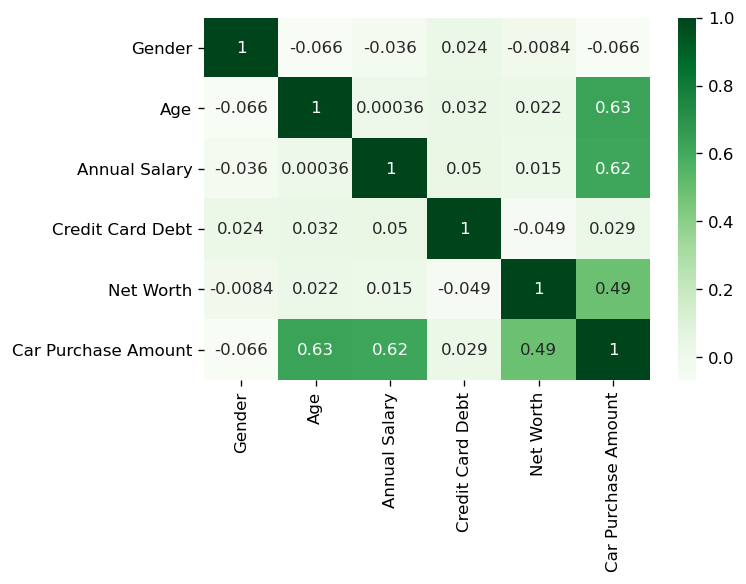

In [17]:
plt.figure(dpi=120)
sns.heatmap(data=dataset.corr(), annot=True, cmap='Greens')

#### Scatter Plots
To check the relationship of gender, a categorical attribute, with the prediction target or any of the features which we have determined to have a high correlation with the prediction target, I have chosen to create scatter plots using gender as a hue in order to investigate trends per gender.

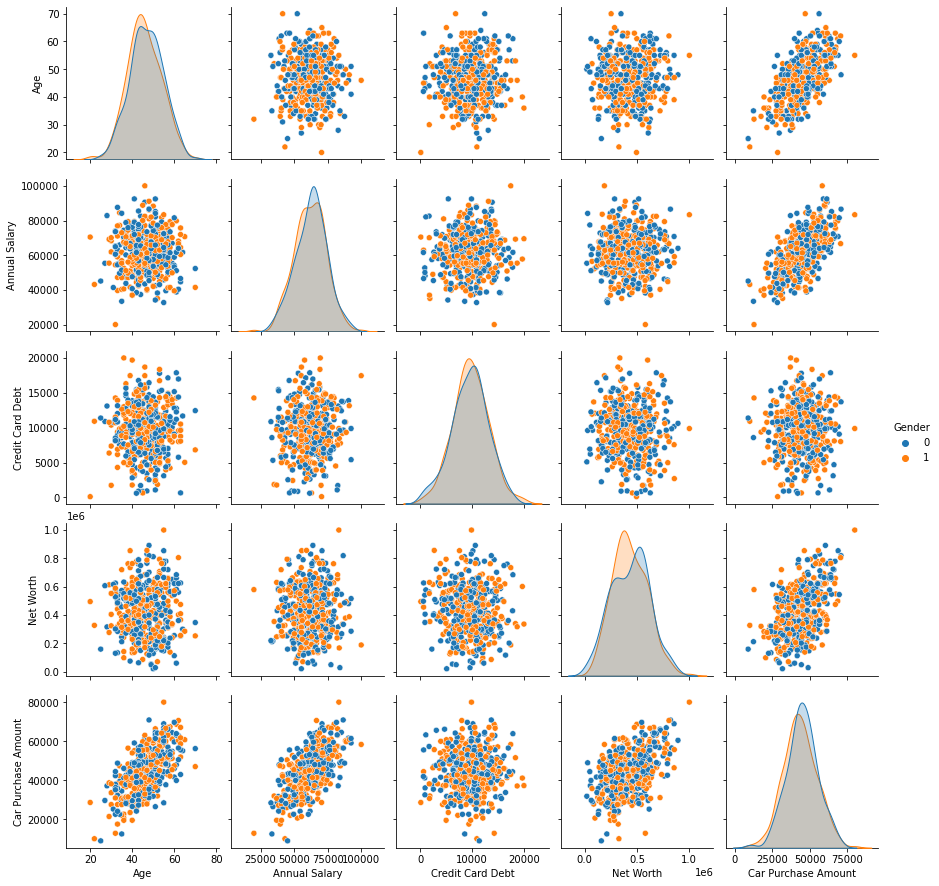

In [18]:
#  It can be seen that Credit Card Debt has no linear relationship with the prediction target 'Car Purchase Amount'
#  From the plots below, women spent more on vehicles compared to men so gender will be included amongst features.
sns.pairplot(dataset[['Age', 'Annual Salary', 'Credit Card Debt', 'Net Worth', 'Car Purchase Amount', 'Gender']], hue='Gender')

From the plots above, although there are no disearnable patterns in the scatter plots for each gender, the fact that women spent more on vehicles seems like an interesting development and I will therefore include gender in the list of model features.

In [19]:
#  List of vital features
vital_features = ['Gender', 'Age', 'Annual Salary', 'Net Worth']

#  Creating feature matrix and response vector
X_all = dataset[vital_features].copy()
y_all = dataset['Car Purchase Amount'].copy()

#  Creating test split
X, X_test, y, y_test = train_test_split(X_all, y_all, test_size=0.05, random_state=0)

#  Creating training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

## Scikit Learn Linear Regression Model

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

min_max_scaler = MinMaxScaler()

#  Creating preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('scaler', min_max_scaler, vital_features)
])

#  Instantiating model
scikit_model = LinearRegression()

#  Creating pipeline
scikit_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', scikit_model)
])

#  Fitting
scikit_pipeline.fit(X_train, y_train)

#  Parameters
print('Parameters of the scikit learn model\n')
print(f'Feature coefficients: {scikit_pipeline[-1].coef_}')
print(f'Bias: {scikit_pipeline[-1].intercept_}')

Parameters of the scikit learn model

Feature coefficients: [2.14735521e+01 4.20459451e+04 4.50204557e+04 2.83253195e+04]
Bias: -13440.612743158032


In [21]:
#  Defining prediction plot function
def plot_pred(x, y, title):
    """This function plots actual values against model predictions"""
    plt.figure(dpi=120)
    sns.regplot(x=x, y=y)
    plt.xlabel('model prediction')
    plt.ylabel('actual values')
    plt.title(title)

In [22]:
from sklearn.metrics import mean_absolute_error
#  Scoring
scikit_prediction = scikit_pipeline.predict(X_val)
#  Loss
scikit_mea = mean_absolute_error(y_val, scikit_prediction)

print(f'Predictions made with the scikit learn model will be off on average by ${round(scikit_mea, 2)}')

Predictions made with the scikit learn model will be off on average by $204.7


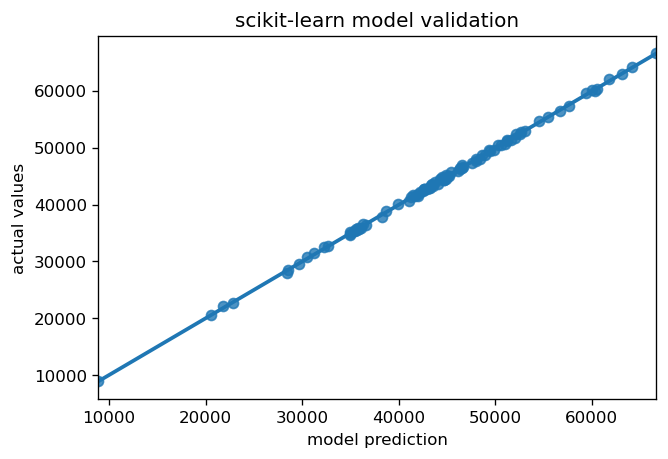

In [23]:
#  Plotting
plot_pred(x=scikit_prediction, y=y_val, title='scikit-learn model validation')

In [24]:
#  Testing
scikit_test_prediction = scikit_pipeline.predict(X_test)
#  Loss
scikit_test_mea = mean_absolute_error(y_test, scikit_test_prediction)

print(f'The scikit learn model predicts test data to a +-${round(scikit_test_mea, 2)} error margin')

The scikit learn model predicts test data to a +-$209.94 error margin


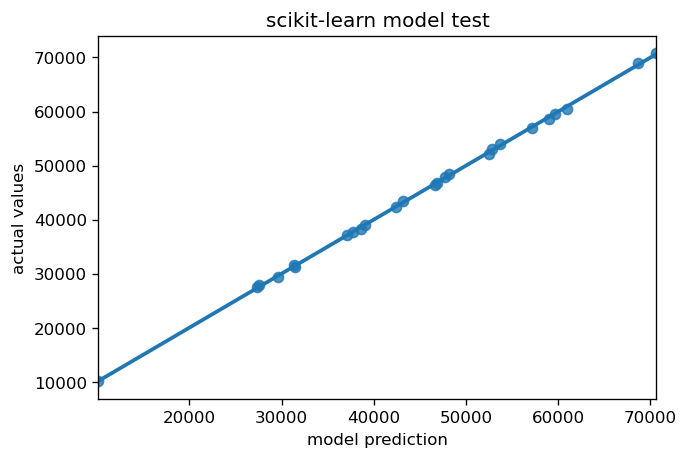

In [25]:
#  Plotting
plot_pred(x=scikit_test_prediction, y=y_test, title='scikit-learn model test')

## Gradient Descent Implementation

In [26]:
import time

class GradientDescentModel():
    """This class models the linear regression model utilising gradient descent"""
    def __init__(self):
        """Initialisation Method"""
        
    def fit(self, X, y):
        """This method learns parameters from the dataset"""
        #  Initialising timer
        start = time.time()
        #  Instantiating scaler
        self.scaler = MinMaxScaler()
        #  Turning DataFrame into array
        X = np.array(X)
        #  Scaling X
        X = self.scaler.fit_transform(X)
        #  Defining (m,n) array of ones
        temp = np.ones((X.shape[0], (X.shape[1]+1)))
        #  Assingning all but the first column to X
        temp[:, 1:] = X
        #  Assigning X to temp
        X = temp
        #  Reshaping y
        y = np.array(y).reshape(X.shape[0], 1)
        #  Defining learning rate
        alpha = 0.3
        #  Defining number of instances m
        m = X.shape[0]
        #  Instantiating parameters
        theta = np.random.rand(X.shape[1], 1)
        #  Instantiating counter
        i=0
        #  Gradient descent
        while True:
            i+=1
            hypothesis = X @ theta
            error = hypothesis - y
            derivative = (alpha/m)*(error.transpose() @ X)
            theta-=derivative.transpose()
            if i == 4000:
                break
        self.theta = theta
        #  Creating coefficients attribute
        self.coefficients_ = theta[1:]
        #  Creating intercept attribute
        self.intercept_ = theta[0]
        #  Creating runtime attribute
        end = time.time()
        self.runtime = start - end
        pass
    
    def predict(self, X):
        """This method predicts over a feature matrix"""
        #  Scaling feature matrix
        X = self.scaler.transform(X)
        #  Creating default bias
        temp = np.ones((X.shape[0], X.shape[1]+1))
        temp[:,1:] = X
        X = temp
        #  Converting feature matrix to array
        X = np.array(X)
        #  Generating predictions
        return X @ self.theta

In [27]:
#  Instantiating model
gd_model = GradientDescentModel()

#  Fitting
gd_model.fit(X_train, y_train)

#  Parameters
print('Parameters of the manualy implemented gradient descent linear regression model\n')
print(f'Feature coefficients: {gd_model.coefficients_.flatten()}')
print(f'Bias: {gd_model.intercept_}')

Parameters of the manualy implemented gradient descent linear regression model

Feature coefficients: [2.14734606e+01 4.20459439e+04 4.50204540e+04 2.83253189e+04]
Bias: [-13440.61084242]


In [28]:
#  Scoring
gd_prediction = gd_model.predict(X_val)
#  Loss
gd_mea = mean_absolute_error(y_val, gd_prediction)

print(f'Predictions made with the gradient descent model will be off on average by ${round(scikit_mea, 2)}')

Predictions made with the gradient descent model will be off on average by $204.7


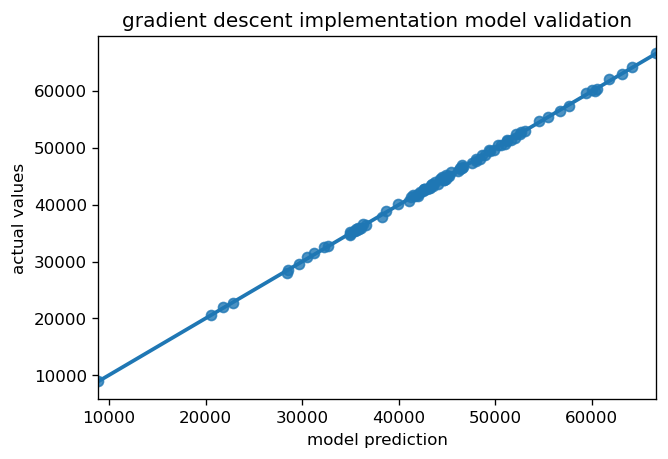

In [29]:
#  Plotting
plot_pred(x=gd_prediction, y=y_val, title='gradient descent implementation model validation')

In [30]:
#  Testing
gd_test_prediction = gd_model.predict(X_test)
#  Loss
gd_test_mea = mean_absolute_error(y_test, gd_test_prediction)

print(f'The gradient descent model predicts test data to a +-${round(gd_test_mea, 2)} error margin')

The gradient descent model predicts test data to a +-$209.94 error margin


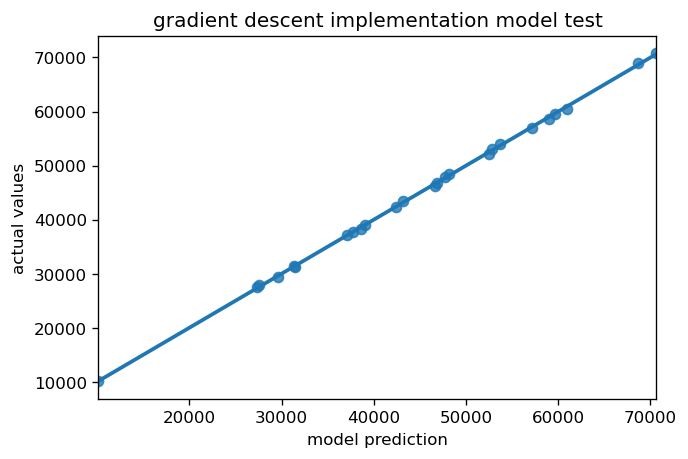

In [31]:
#  Plotting
plot_pred(x=gd_test_prediction, y=y_test, title='gradient descent implementation model test')

## Normal Equation Implementation

In [32]:
class NormalEquation():
    """This class models a linear regression model using the normal equation"""
    def __init__(self):
        """This is the initialisation method"""
        
    def fit(self, X, y):
        """This method learns parameters from dataset"""
        #  Converting feature matrix to array
        X = np.array(X)
        #  Creating column for default bias
        temp = np.ones((X.shape[0], X.shape[1]+1))
        temp[:,1:] = X
        X = temp
        #  Converting y to array
        y = np.array(y).reshape((y.shape[0], 1))
        spam = np.linalg.pinv(X.transpose() @ X)
        eggs = X.transpose() @ y
        self.theta_ne = spam @ eggs
        #  Creating coefficient attribute
        self.coefficients = self.theta_ne[1:]
        #  Creating intercept attribute
        self.intercept = self.theta_ne[0]
        pass
    
    def predict(self, X):
        """This method predicts over the validation set"""
        #  Converting feature matrix to array
        X = np.array(X)
        #  Creating column of default bias
        temp = np.ones((X.shape[0], X.shape[1]+1))
        temp[:,1:] = X
        X = temp
        #  Predicting
        return X @ self.theta_ne

In [33]:
#  Instantiating model
ne_model = NormalEquation()

#  Fitting model
ne_model.fit(X_train, y_train)

#  Parameters
print('Parameters of the manualy implemented normal equation linear regression model\n')
print(f'Feature coefficients: {ne_model.coefficients.flatten()}')
print(f'Bias: {ne_model.intercept}')

Parameters of the manualy implemented normal equation linear regression model

Feature coefficients: [2.14735625e+01 8.40918905e+02 5.62755698e-01 2.89033873e-02]
Bias: [-42092.17272183]


In [34]:
#  Scoring
ne_prediction = ne_model.predict(X_val)
#  Loss
ne_mea = mean_absolute_error(y_val, ne_prediction)

print(f'Predictions made with the normal equation model will be off on average by ${round(scikit_mea, 2)}')

Predictions made with the normal equation model will be off on average by $204.7


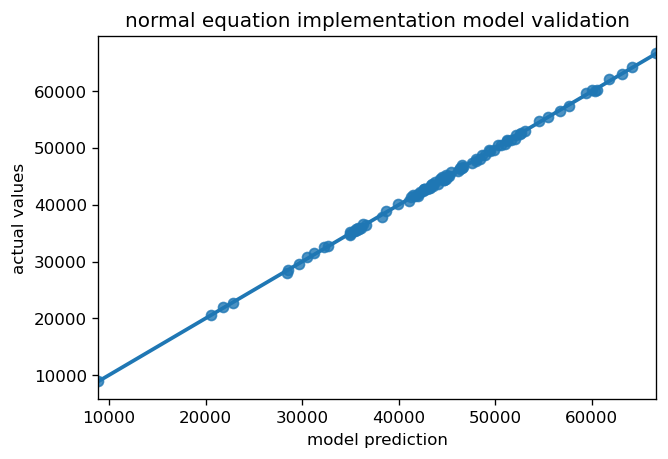

In [35]:
#  Plotting
plot_pred(x=ne_prediction, y=y_val, title='normal equation implementation model validation')

In [36]:
#  Testing
ne_test_prediction = ne_model.predict(X_test)
#  Loss
ne_test_mea = mean_absolute_error(y_test, gd_test_prediction)

print(f'The normal equation model predicts test data to a +-${round(ne_test_mea, 2)} error margin')

The normal equation model predicts test data to a +-$209.94 error margin


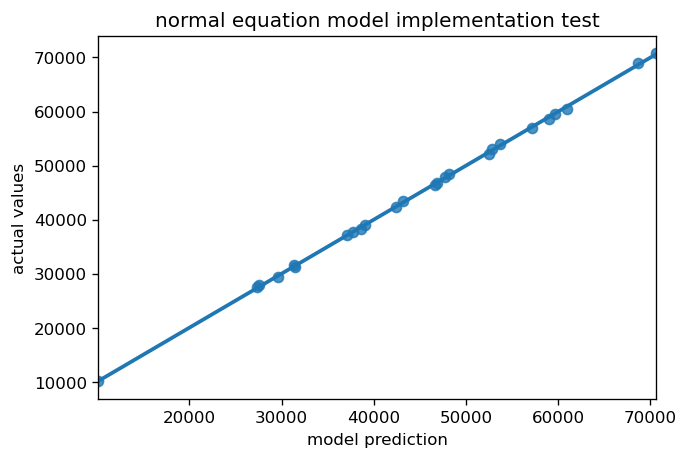

In [37]:
#  Plotting
plot_pred(x=ne_test_prediction, y=y_test, title='normal equation model implementation test')

## SHAP Values

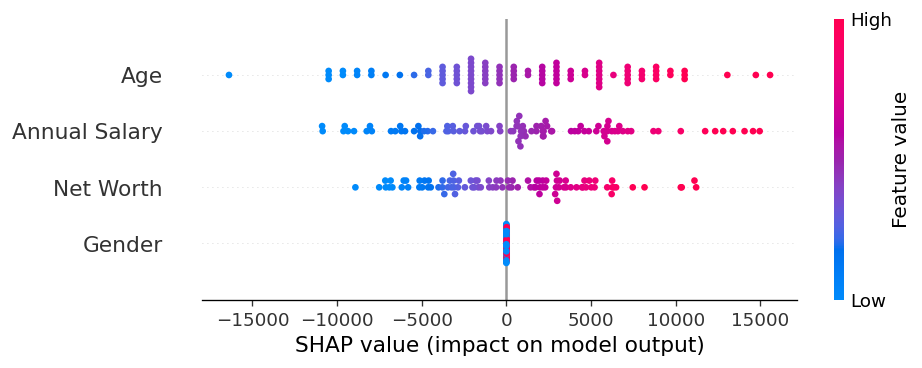

In [76]:
import shap
#  Object to calculate SHAP values 
explainer = shap.LinearExplainer(scikit_pipeline[-1], scikit_pipeline[0].transform(X_train))

#  Calculating SHAP values
shap_vals = explainer.shap_values(scikit_pipeline[0].transform(X_val))

#  Plotting
shap.initjs()
plt.figure(dpi=120)
shap.summary_plot(shap_vals, pd.DataFrame(scikit_pipeline[0].transform(X_val), columns=X_val.columns))

In [90]:
#  Individual SHAP plots
shap.initjs()
def shap_plot_ind(j):
    return shap.force_plot(explainer.expected_value, shap_vals[j], X_val.iloc[j,:])
    
shap_plot_ind(22)